# Unsupervised Generative PC on MNIST

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thebuckleylab/jpc/blob/main/examples/unsupervised_generative_pc.ipynb)

This notebook demonstrates how to train a simple feedforward network with predictive coding to encode MNIST digits in an unsupervised manner.

In [1]:
# %%capture
# !pip install torch==2.3.1
# !pip install torchvision==0.18.1
# !pip install matplotlib==3.0.0

In [2]:
import jpc

import jax
import equinox as eqx
import equinox.nn as nn
import optax
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.simplefilter('ignore')  # ignore warnings

## Hyperparameters

We define some global parameters, including the network architecture, learning rate, batch size, etc.

In [3]:
SEED = 0

INPUT_DIM = 10  # Changed from 50 to 10 to match one-hot encoded labels
WIDTH = 300
DEPTH = 3
OUTPUT_DIM = 784
ACT_FN = "relu"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_T1 = 100
N_TRAIN_ITERS = 300

## Dataset

Some utils to fetch and plot MNIST.

In [4]:
# def get_mnist_loaders(batch_size):
#     train_data = MNIST(train=True, normalise=True)
#     test_data = MNIST(train=False, normalise=True)
#     train_loader = DataLoader(
#         dataset=train_data,
#         batch_size=batch_size,
#         shuffle=True,
#         drop_last=True
#     )
#     test_loader = DataLoader(
#         dataset=test_data,
#         batch_size=batch_size,
#         shuffle=True,
#         drop_last=True
#     )
#     return train_loader, test_loader


# class MNIST(datasets.MNIST):
#     def __init__(self, train, normalise=True, save_dir="data"):
#         if normalise:
#             transform = transforms.Compose(
#                 [
#                     transforms.ToTensor(),
#                     transforms.Normalize(
#                         mean=(0.1307), std=(0.3081)
#                     )
#                 ]
#             )
#         else:
#             transform = transforms.Compose([transforms.ToTensor()])
#         super().__init__(save_dir, download=True, train=train, transform=transform)

#     def __getitem__(self, index):
#         img, _ = super().__getitem__(index)
#         img = torch.flatten(img)
#         return img



def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label
    


def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


## Plotting

In [5]:
def plot_train_energies(energies, ts):
    t_max = int(ts[0])
    norm = mcolors.Normalize(vmin=0, vmax=len(energies)-1)
    fig, ax = plt.subplots(figsize=(8, 4))
    
    cmap_blues = plt.get_cmap("Blues")
    cmap_reds = plt.get_cmap("Reds")
    cmap_greens = plt.get_cmap("Greens")
    
    legend_handles = []
    legend_labels = []
    
    for t, energies_iter in enumerate(energies):
        line1, = ax.plot(energies_iter[0, :t_max], color=cmap_blues(norm(t)))
        line2, = ax.plot(energies_iter[1, :t_max], color=cmap_reds(norm(t)))
        line3, = ax.plot(energies_iter[2, :t_max], color=cmap_greens(norm(t)))
    
        if t == 70:
            legend_handles.append(line1)
            legend_labels.append("$\ell_1$")
            legend_handles.append(line2)
            legend_labels.append("$\ell_2$")
            legend_handles.append(line3)
            legend_labels.append("$\ell_3$")
    
    ax.legend(legend_handles, legend_labels, loc="best", fontsize=16)
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("Greys"), norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Training iteration", fontsize=16, labelpad=14)
    cbar.ax.tick_params(labelsize=14) 
    plt.gca().tick_params(axis="both", which="major", labelsize=16)
    
    ax.set_xlabel("Inference iterations", fontsize=18, labelpad=14)
    ax.set_ylabel("Energy", fontsize=18, labelpad=14)
    ax.set_yscale("log")
    plt.show()

## Network

For `jpc` to work, we need to provide a network with callable layers. This is easy to do with the PyTorch-like [`nn.Sequential()`](https://docs.kidger.site/equinox/api/nn/sequential/#equinox.nn.Sequential) in [equinox](https://github.com/patrick-kidger/equinox). For example, we can define a ReLU MLP with two hidden layers as follows

In [6]:
key = jax.random.PRNGKey(SEED)
key, *subkeys = jax.random.split(key, 4)
network = [
    nn.Sequential(
        [
            nn.Linear(10, 300, key=subkeys[0]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Sequential(
        [
            nn.Linear(300, 300, key=subkeys[1]),
            nn.Lambda(jax.nn.relu)
        ],
    ),
    nn.Linear(300, 784, key=subkeys[2]),
]

You can also use [`jpc.make_mlp()`](https://thebuckleylab.github.io/jpc/api/Utils/#jpc.make_mlp) to define a multi-layer perceptron (MLP) or fully connected network.

In [7]:
network = jpc.make_mlp(
    key,
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    act_fn=ACT_FN,
    use_bias=True
)
print(network)

[Sequential(
  layers=(
    Lambda(fn=Identity()),
    Linear(
      weight=f32[300,10],
      bias=f32[300],
      in_features=10,
      out_features=300,
      use_bias=True
    )
  )
), Sequential(
  layers=(
    Lambda(fn=<PjitFunction of <function relu at 0x72c3bbd1eca0>>),
    Linear(
      weight=f32[300,300],
      bias=f32[300],
      in_features=300,
      out_features=300,
      use_bias=True
    )
  )
), Sequential(
  layers=(
    Lambda(fn=<PjitFunction of <function relu at 0x72c3bbd1eca0>>),
    Linear(
      weight=f32[784,300],
      bias=f32[784],
      in_features=300,
      out_features=784,
      use_bias=True
    )
  )
)]


## Train

A PC network can be updated in a single line of code with [`jpc.make_pc_step()`](https://thebuckleylab.github.io/jpc/api/Training/#jpc.make_pc_step), which is already "jitted" for optimised performance. To train in an unsupervised way, we simply avoid providing an `input` to [`jpc.make_pc_step()`](https://thebuckleylab.github.io/jpc/api/Training/#jpc.make_pc_step). To test the learned encoding or representation for downstream accuracy, you could simply add a classifier.

In [8]:
def evaluate(key, layer_sizes, batch_size, network, test_loader, max_t1):
    test_acc = 0
    for _, (img_batch, label_batch) in enumerate(test_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        acc, img_preds = jpc.test_generative_pc(
            model=network,
            input=label_batch,
            output=img_batch,
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            max_t1=max_t1
        )
        test_acc += acc

    avg_test_acc = test_acc / len(test_loader)

    return avg_test_acc, label_batch, img_preds

def plot_mnist_imgs(imgs, labels, n_imgs=16):

    rows = np.sqrt(n_imgs).astype(int)
    cols = int(np.ceil(n_imgs / rows))

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axs = axs.flatten()
    for i in range(n_imgs):
        ax = axs[i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.binary_r)
        ax.set_xlabel(jnp.argmax(labels, axis=1)[i])
    return fig


def train(
    key,
    input_dim,
    width,
    depth,
    output_dim,
    batch_size,
    network,
    lr,
    max_t1,
    n_train_iters
):
    layer_sizes = [input_dim] + [width]*(depth-1) + [output_dim]
    optim = optax.adam(lr)
    opt_state = optim.init(
        (eqx.filter(network, eqx.is_array), None)
    )
    train_loader, test_loader = get_mnist_loaders(batch_size)

    train_energies, ts = [], []
    for iter, single_batch in tqdm(enumerate(train_loader), total = len(train_loader)):
        img_batch, _ = single_batch
        img_batch = img_batch.numpy()


        result = jpc.make_pc_step(
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            model=network,
            optim=optim,
            opt_state=opt_state,
            output=img_batch,
            max_t1=max_t1,
            record_activities=True,
            record_energies=True
        )
        network, opt_state = result["model"], result["opt_state"]
        train_energies.append(result["energies"])
        ts.append(result["t_max"])

        if ((iter+1) % 500) == 0 or (iter+1) == n_train_iters:
            avg_test_acc, test_label_batch, img_preds = evaluate(
                key,
                layer_sizes,
                batch_size,
                network,
                test_loader,
                max_t1=max_t1
            )
            loss_str = f"{result['loss']:4f}" if result['loss'] is not None else "N/A"
            print(
                f"Train iter {iter+1}, train loss={loss_str}, train energy={result['energies'][:, -1].sum():4f}, "
                f"avg test accuracy={avg_test_acc:4f}"
            )
            if (iter+1) >= n_train_iters:
                break
        
    plot_mnist_imgs(img_preds, test_label_batch, n_imgs=16)
    return result["model"], train_energies, ts


## Run
Below we simply plot the energy dynamics of each layer during both inference and learning.

 32%|███▏      | 299/937 [01:55<04:06,  2.59it/s]

Train iter 300, train loss=N/A, train energy=0.000000, avg test accuracy=6.560497


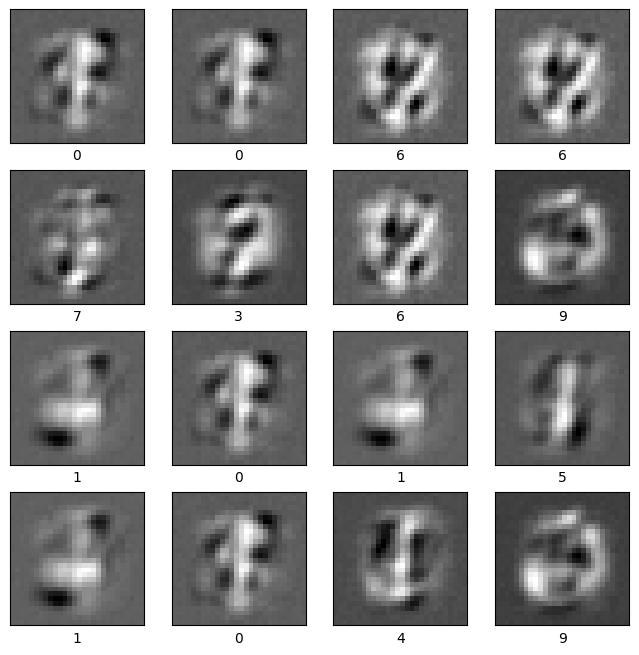

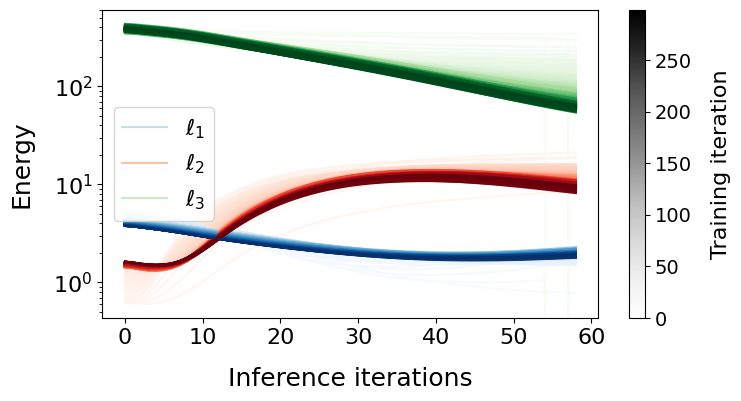

In [9]:
network, energies, ts = train(
    key=key,
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    batch_size=BATCH_SIZE,
    network=network,
    lr=LEARNING_RATE,
    max_t1=MAX_T1,
    n_train_iters=N_TRAIN_ITERS
)
plot_train_energies(energies, ts)